In [9]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
from sklearn.base import clone
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from gensim.models import Word2Vec
from xgboost import XGBClassifier

from data_utils import clean_data


In [10]:
# fetching pre-labelled data

df=pd.read_csv("https://raw.githubusercontent.com/edwardcqian/climate_change_sentiment/master/data/sample_data.csv")

We only consider tweets with positive, negative or neutral stance. Tweets without stance i.e. news or just information about climate change are not considered.

In [11]:
df=df.loc[df['sentiment']!=2]
df=df.reset_index(drop=True)
df.shape

(34667, 3)

In [12]:
df['clean_data'] = df['message'].apply(clean_data)
df=df[['sentiment','clean_data','message']]

df_train,df_test=train_test_split(df,test_size=0.2,shuffle=True,stratify=df['sentiment'],
                                  random_state=42).copy()
df_train['sentiment'].value_counts(normalize=True)

def clean(tweet):
    '''
    cleaning all special symbols
    '''
    tweet=re.sub(r'( rt)|(rt )|( htt)|(htt )',"",tweet,flags=re.IGNORECASE)
    tweet=re.sub(r'Ã¢â‚¬Â¦',"",tweet,flags=re.IGNORECASE)
    return tweet

df_train['clean_data']=df_train['clean_data'].apply(clean)
df_test['clean_data']=df_test['clean_data'].apply(clean)

Now we plot the distribution of the data, we have many more positive stance tweets than negative and neutral ones.

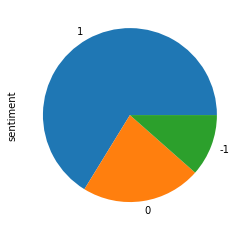

In [13]:
df_train.sentiment.value_counts(normalize=True).plot(kind='pie')
df_train=df_train.reset_index(drop=False)

### CountVectorizer Model 

In [14]:
# we choose initial vocal_size=3000
cv = CountVectorizer(max_features=3000)

# We transform each text into a vector
cd_features = cv.fit_transform(df_train.clean_data).toarray()
cd_labels = df_train.sentiment
cd_features.shape

(27733, 3000)

In [15]:
# our choice of models

models = [
    BernoulliNB(),
    LogisticRegression(C=1,max_iter=1000),
    MultinomialNB(),
]

In [16]:
CV=5

#cross validate accuracy and f1_macro 

cv_df = pd.DataFrame(index=range( CV* len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    scores = cross_validate(model, cd_features, cd_labels, scoring=('accuracy','f1_macro'), cv=CV)
    for i in range(1,CV+1):
        entries.append((model_name, i, scores['test_accuracy'][i-1],scores['test_f1_macro'][i-1]))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy','f1_macro'])

In [17]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
acc_std=cv_df.groupby('model_name').accuracy.std()
mean_f1_macro = cv_df.groupby('model_name').f1_macro.mean()
f1_std=cv_df.groupby('model_name').f1_macro.std()

cv_acc = pd.concat([mean_accuracy,acc_std, mean_f1_macro,f1_std], axis= 1, 
          ignore_index=True)
cv_acc.columns = ['Mean_accuracy','Acc_std','Mean F1_macro','F1_std']
cv_acc

,Mean_accuracy,Acc_std,Mean F1_macro,F1_std
model_name,,,,
BernoulliNB,0.721883,0.009062,0.626366,0.010449
LogisticRegression,0.758879,0.002074,0.655158,0.005965
MultinomialNB,0.730069,0.006450,0.636349,0.009350


Seems like LogisticRegression performs the best with highest accuracy and mean F1_macro.

### TF-IDF Model

In [18]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3,
                        max_features=3000,
                        ngram_range=(1,3), # considering unigram, bigram and tri-gram
                        stop_words='english')

# We transform each text into a vector
tfidf_features = tfidf.fit_transform(df_train.clean_data).toarray()

tfidf_labels = df_train.sentiment

In [19]:
CV=5

#cross validate accuracy and f1_macro 

tfidf_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    scores = cross_validate(model, tfidf_features, tfidf_labels, scoring=('accuracy','f1_macro'), cv=CV)
    for i in range(1,CV+1):
        entries.append((model_name, i, scores['test_accuracy'][i-1],scores['test_f1_macro'][i-1]))
    
tfidf_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy','f1_macro'])

In [20]:
mean_accuracy = tfidf_df.groupby('model_name').accuracy.mean()
acc_std = tfidf_df.groupby('model_name').accuracy.std()
mean_f1_macro = tfidf_df.groupby('model_name').f1_macro.mean()
f1_std = tfidf_df.groupby('model_name').f1_macro.std()

tfidf_acc = pd.concat([mean_accuracy,acc_std, mean_f1_macro,f1_std], axis= 1, 
          ignore_index=True)
tfidf_acc.columns = ['Mean_accuracy','Acc_std','Mean F1_macro','F1_std']
tfidf_acc

,Mean_accuracy,Acc_std,Mean F1_macro,F1_std
model_name,,,,
BernoulliNB,0.682833,0.006207,0.595116,0.006310
LogisticRegression,0.753543,0.001352,0.623888,0.005582
MultinomialNB,0.731619,0.003806,0.580213,0.005743


Both LogisticRegression and MultinomialNB works greats, but the macro F1_scores are considerably lower than the CountVectorizer model.

### Word2Vec Model

In [21]:
%%time

tokenized_tweet = df_train['clean_data'].apply(lambda x: x.split()) # tokenizing 

model_w2v = Word2Vec(
            tokenized_tweet,
            size=300, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 20, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokenized_tweet, total_examples= len(df_train['clean_data']), epochs=20)

CPU times: user 6min 4s, sys: 1.84 s, total: 6min 6s
Wall time: 52.6 s


(6315826, 9154660)

In [22]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [23]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 300)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 300)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

/var/folders/58/fw1mf93d4gxg7d40q7fc5hj00000gn/T/ipykernel_5589/814884412.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += model_w2v[word].reshape((1, size))


(27733, 300)

In [24]:
wv_models = [
    BernoulliNB(),
    LogisticRegression(C=1,max_iter=1000),
    KNeighborsClassifier(3),
    RandomForestClassifier(n_estimators=200,max_depth=10,random_state=110),
    AdaBoostClassifier(),
    LinearDiscriminantAnalysis(),
]

ytrain=df_train.sentiment
xtrain_w2v = np.array(wordvec_df.iloc[range(len(ytrain)),:])

In [25]:
%%time
CV=5
wv_df = pd.DataFrame(index=range( CV* len(wv_models)))
entries = []
for model in wv_models:
    model_name = model.__class__.__name__
    scores = cross_validate(model, xtrain_w2v, ytrain, scoring=('accuracy','f1_macro'), cv=CV,error_score='raise')
    for i in range(1,CV+1):
        entries.append((model_name, i, scores['test_accuracy'][i-1],scores['test_f1_macro'][i-1]))
    
wv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy','f1_macro'])

CPU times: user 9min 58s, sys: 16 s, total: 10min 14s
Wall time: 7min 30s


In [26]:
mean_accuracy = wv_df.groupby('model_name').accuracy.mean()
mean_f1_macro = wv_df.groupby('model_name').f1_macro.mean()


wv_acc = pd.concat([mean_accuracy, mean_f1_macro], axis= 1, 
          ignore_index=True)
wv_acc.columns = ['Mean_accuracy','Mean F1_macro']
wv_acc

,Mean_accuracy,Mean F1_macro
model_name,,
AdaBoostClassifier,0.696571,0.522986
BernoulliNB,0.662135,0.532289
KNeighborsClassifier,0.705008,0.569618
LinearDiscriminantAnalysis,0.744600,0.603357
LogisticRegression,0.749180,0.607533
RandomForestClassifier,0.712364,0.436652


Logistic Regression again has the higest accuracy, but the mean F1_macro scores are considerably lower than CV and TD-IDF models.

Since we have only 300 features, we will use the powerful XGBoost model and check if there are any improvements in metrics.

In [27]:
#prepping for xgboost model
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_w2v = wordvec_df
ytrain=label_encoder.fit_transform(df_train.sentiment)

xtrain_w2v = np.array(train_w2v.iloc[range(len(ytrain)),:])

xgb=XGBClassifier(max_depth=5,use_label_encoder=False,eval_metric='mlogloss')

In [28]:
scores = cross_validate(xgb, xtrain_w2v, ytrain, scoring='accuracy',cv=CV)

print('Mean accuracy score for  test set',scores['test_score'].mean())

XGBoost seems to perform better than the models we have considered, let us check the F1_macro scores for a smaller subset.

In [ ]:
train_w2v = wordvec_df.iloc[:10000,:]
ytrain=label_encoder.fit_transform(df_train.sentiment[:10000])
xtrain_w2v = np.array(train_w2v.iloc[range(len(ytrain)),:])

test_w2v = wordvec_df.iloc[10000:13000,:]
ytest=label_encoder.fit_transform(df_train.sentiment[10000:13000])
xtest_w2v = np.array(test_w2v.iloc[:,:])

xgb=XGBClassifier(max_depth=5,use_label_encoder=False,eval_metric='mlogloss')

In [ ]:
xgb.fit(xtrain_w2v,ytrain)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [ ]:
print(classification_report(xgb.predict(xtest_w2v),ytest))

              precision    recall  f1-score   support

           0       0.31      0.65      0.42       172
           1       0.39      0.61      0.48       419
           2       0.93      0.77      0.84      2409

    accuracy                           0.74      3000
   macro avg       0.55      0.68      0.58      3000
weighted avg       0.82      0.74      0.77      3000



Seems like XGBoost model attains good accuracy but the F1_macro scores are lower than previous logistic regression models.

We will use three models: CV LogisticReg, TF-IDF LogisticReg and WordVec XGBoost Models and check on validation sets.

In [ ]:
cv_pipe=Pipeline([('cv', CountVectorizer(max_features=3000)), ('lreg', LogisticRegression(max_iter=1000))])
tfidf_pipe=Pipeline([('cv', TfidfVectorizer(sublinear_tf=True, min_df=3,
                        max_features=3000,ngram_range=(1,3),
                        
                        stop_words='english')), ('lreg', LogisticRegression(max_iter=1000))])


In [ ]:
skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=10)

In [ ]:
%%time
kf=pd.DataFrame(index=range( 5* 3))
entries=[]
X=df_train['clean_data']
y=df_train['sentiment']
i=0
for train_index,test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    cv_pipe.fit(X_train,y_train)
    y_pred=cv_pipe.predict(X_test)
    entries.append(("CountVect",
                    accuracy_score(y_pred,y_test),
                   f1_score(y_pred,y_test,average='macro')))
    tfidf_pipe.fit(X_train,y_train)
    y_pred=tfidf_pipe.predict(X_test)
    entries.append(("TF-IDF",
                    accuracy_score(y_pred,y_test),
                   f1_score(y_pred,y_test,average='macro')))
    X_train=np.array(wordvec_df.iloc[train_index])
    y_train=label_encoder.fit_transform(y[train_index])
    xgb=clone(xgb)
    xgb.fit(X_train,y_train)
    X_test=np.array(wordvec_df.iloc[test_index])
    y_test=label_encoder.fit_transform(y[test_index])
    y_pred=xgb.predict(X_test)
    entries.append(("XGBoost",
                    accuracy_score(y_pred,y_test),
                   f1_score(y_pred,y_test,average='macro')))
    i=i+1
    print(str(i)+" split ended.")
    
            

1 split ended.
2 split ended.
3 split ended.
4 split ended.
5 split ended.
CPU times: user 51min 38s, sys: 6.17 s, total: 51min 44s
Wall time: 7min 6s


In [ ]:
kf = pd.DataFrame(entries, columns=['model_name', 'accuracy','f1_macro'])
kf

,model_name,accuracy,f1_macro
0,CountVect,0.757707,0.657753
1,TF-IDF,0.748873,0.620140
2,XGBoost,0.749234,0.604712
3,CountVect,0.757887,0.649516
4,TF-IDF,0.753560,0.619591
5,XGBoost,0.766180,0.634079
6,CountVect,0.767802,0.665269
7,TF-IDF,0.761312,0.636402
8,XGBoost,0.759149,0.628175
9,CountVect,0.754778,0.643564


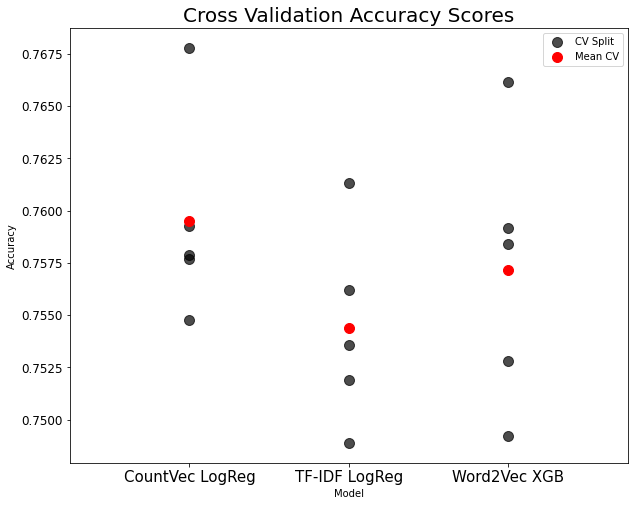

In [ ]:
plt.figure(figsize=(10,8))

plt.scatter(np.ones(5), kf[kf['model_name']=='CountVect']['accuracy'],
               s=100,
               c='k',
               alpha=.7,
               label="CV Split")
plt.scatter([1], np.mean(kf[kf['model_name']=='CountVect']['accuracy']),
               s=100,
               c='r',
               alpha=1,
               label="Mean CV")


plt.scatter(2*np.ones(5), kf[kf['model_name']=='TF-IDF']['accuracy'],
               s=100,
               c='k',
               alpha=.7)
plt.scatter([2], np.mean(kf[kf['model_name']=='TF-IDF']['accuracy']),
               s=100,
               c='r',
               alpha=1)
plt.scatter(3*np.ones(5), kf[kf['model_name']=='XGBoost']['accuracy'], 
               s=100,
               c='k',
               alpha=.7)
plt.scatter([3], np.mean(kf[kf['model_name']=='XGBoost']['accuracy']),
               s=100,
               c='r',
               alpha=1)

plt.xlim(0.25,3.75)
plt.xticks([1,2,3], ["CountVec LogReg", "TF-IDF LogReg", "Word2Vec XGB"], fontsize=15)
plt.yticks(fontsize=12)
plt.xlabel("Model", fontsize=10)
plt.ylabel("Accuracy", fontsize=10)
plt.legend(fontsize=10)
plt.title("Cross Validation Accuracy Scores",fontsize=20)
plt.show()



Looks like ``CountVectorizer Logistic Regression`` has the best accuracy scores, but since our dataset is imbalanced we will be also looking at f1_macro scores.

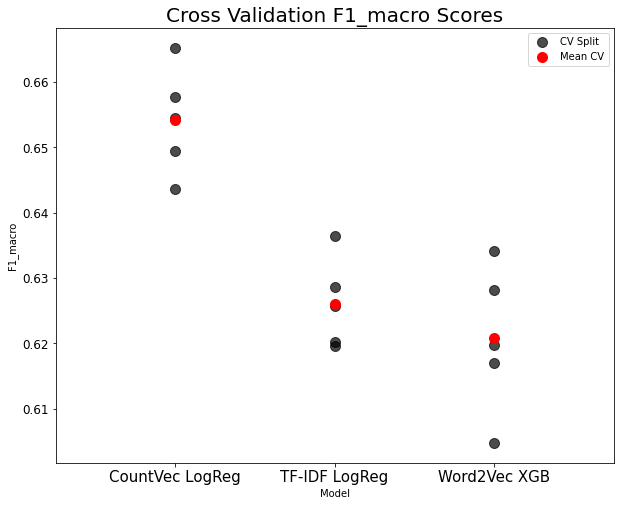

In [ ]:
plt.figure(figsize=(10,8))

plt.scatter(np.ones(5), kf[kf['model_name']=='CountVect']['f1_macro'],
               s=100,
               c='k',
               alpha=.7,
               label="CV Split")
plt.scatter([1], np.mean(kf[kf['model_name']=='CountVect']['f1_macro']),
               s=100,
               c='r',
               alpha=1,
               label="Mean CV")


plt.scatter(2*np.ones(5), kf[kf['model_name']=='TF-IDF']['f1_macro'],
               s=100,
               c='k',
               alpha=.7)
plt.scatter([2], np.mean(kf[kf['model_name']=='TF-IDF']['f1_macro']),
               s=100,
               c='r',
               alpha=1)
plt.scatter(3*np.ones(5), kf[kf['model_name']=='XGBoost']['f1_macro'], 
               s=100,
               c='k',
               alpha=.7)
plt.scatter([3], np.mean(kf[kf['model_name']=='XGBoost']['f1_macro']),
               s=100,
               c='r',
               alpha=1)

plt.xlim(0.25,3.75)
plt.xticks([1,2,3], ["CountVec LogReg", "TF-IDF LogReg", "Word2Vec XGB"], fontsize=15)
plt.yticks(fontsize=12)
plt.xlabel("Model", fontsize=10)
plt.ylabel("F1_macro", fontsize=10)
plt.legend(fontsize=10)
plt.title("Cross Validation F1_macro Scores",fontsize=20)
plt.show()


Looks like ``CountVectorizer Logistic Regression`` also has the best f1_macro scores, we will choose this model for hypertuning parameters.

### HyperTuning Parameters and number of features

We check whether decreasing or increasing ``max features`` for ``CountVectorizer`` improve accuracy scores and f1_macro. 

In [ ]:
%%time
skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
max_f=[1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]
kf_ft=pd.DataFrame(index=range( 5* len(max_f)))
entries=[]
X=df_train['clean_data']
y=df_train['sentiment']
count=1
for train_index,test_index in skf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for fts in max_f:
        cv_pipe=Pipeline([('cv', CountVectorizer(max_features=fts)), 
                      ('lreg', LogisticRegression(max_iter=1000))])
        cv_pipe.fit(X_train,y_train)
        y_pred=cv_pipe.predict(X_test)
        entries.append((fts,count,
                    accuracy_score(y_pred,y_test),
                   f1_score(y_pred,y_test,average='macro')))
    print(str(count)+ " split ended.")
    count+=1
    

1 split ended.
2 split ended.
3 split ended.
4 split ended.
5 split ended.
CPU times: user 13min 31s, sys: 2min 4s, total: 15min 35s
Wall time: 2min 55s


In [ ]:
kf_ft= pd.DataFrame(entries, columns=['max_features', 'fold_idx','accuracy','f1_macro'])
mean_accuracy = kf_ft.groupby('max_features').accuracy.mean()
mean_f1_macro = kf_ft.groupby('max_features').f1_macro.mean()


acc = pd.concat([mean_accuracy, mean_f1_macro], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean_accuracy','Mean_F1_macro']


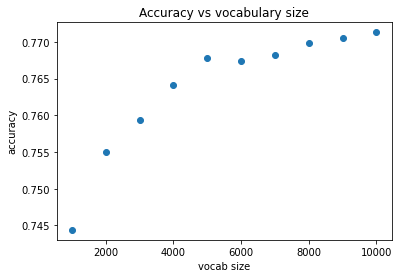

In [ ]:
plt.scatter(max_f, np.array(acc.Mean_accuracy))
plt.xlabel("vocab size")
plt.ylabel("accuracy")
plt.title("Accuracy vs vocabulary size")
plt.show()

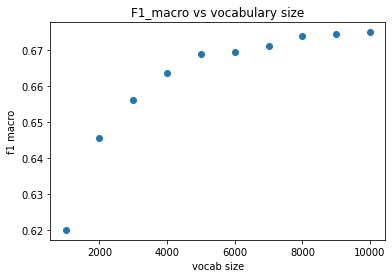

In [ ]:
plt.scatter(max_f, np.array(acc.Mean_F1_macro))
plt.xlabel("vocab size")
plt.ylabel("f1 macro")
plt.title("F1_macro vs vocabulary size")
plt.show()

It seems like accuracies and mean f1_macro more or less increases as the number of features increase. We will choose vocabulary size ``max_features=8000`` for hyper-parameter tuning. As our data-set is imbalanced we will focus more on ``f1_macro`` scores.

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
grid={"C":np.logspace(-2,2,7)} 
lreg=LogisticRegression(max_iter=10000)
scoring = ['accuracy','f1_macro']
lreg_cv=GridSearchCV(lreg,grid,cv=5,
                    scoring=scoring,refit='f1_macro')
X_train=CountVectorizer(max_features=8000).fit_transform(df_train.clean_data)
y_train=df_train.sentiment
lreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",lreg_cv.best_params_)
print("f1_macro :",lreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0}
f1_macro : 0.6737390389340068
CPU times: user 21min 12s, sys: 6min 10s, total: 27min 22s
Wall time: 4min 16s


In [ ]:
lreg=LogisticRegression( C = 1, max_iter=10000)

In [ ]:
cd=CountVectorizer(max_features=8000)
X_train=cd.fit_transform(df_train.clean_data)
y_train=df_train.sentiment
X_test=cd.transform(df_test.clean_data)
y_test=df_test.sentiment


In [ ]:
lreg.fit(X_train,y_train)

LogisticRegression(C=1, max_iter=10000)

In [ ]:
print("Test accuracy : {:.2f}".format(100*accuracy_score(y_test,lreg.predict(X_test))))

Test accuracy : 76.62


In [ ]:
print("Test f1_macro : {:.2f}".format(f1_score(lreg.predict(X_test),y_test,average='macro')))

Test f1_macro : 0.67


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(y_test,lreg.predict(X_test))

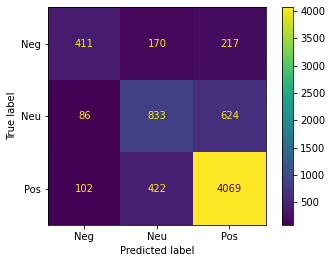

In [ ]:
ConfusionMatrixDisplay(cm,display_labels=["Neg","Neu","Pos"]).plot()

### Conclusion: 

We get a test accuracy of 76.62% on our test data and an f1_macro score of 0.67 using ``LogReg CountVect`` model. We observe that a lot of true negative and neutral stances are being classified as positives, however our model does a good job in classifying the positive stances.

### Climate Change Stance Trends

We now run our model on climate change tweets scraped between 2014 and 2021 (at 100 tweets/day) and view the trends.

In [ ]:
import os
accs=np.zeros((3,3));year=14;
data="data_raw"
paths=["cc_2014","cc_2015","cc_2016","cc_2017","cc_2018","cc_2019","cc_2020","cc_2021"]
for path in paths:
    df_list=[]
    path=os.path.join(data,path)
    for f in os.listdir(path):
        files_path=os.path.join(path,f)
        temp=pd.read_csv(os.path.join(files_path), sep='\t', encoding='utf-8', lineterminator='\n')
        df_list.append(temp)
    df=pd.concat(df_list)
    df=df[['content']]
    df['clean_data']=df['content'].apply(clean_data)
    X=cd.transform(df.clean_data)
    y=lreg.predict(X)
    unique, counts = np.unique(y, return_counts=True)
    accs=np.concatenate((accs,np.asarray((np.ones(3)*year,unique, counts/X.shape[0])).T),axis=0)
    print(str(2000+year) + " done.")
    year=year+1

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.


In [ ]:
accs=accs[3:]
accs

array([[14.        , -1.        ,  0.05348901],
       [14.        ,  0.        ,  0.17901099],
       [14.        ,  1.        ,  0.7675    ],
       [15.        , -1.        ,  0.05173077],
       [15.        ,  0.        ,  0.17961538],
       [15.        ,  1.        ,  0.76865385],
       [16.        , -1.        ,  0.0471978 ],
       [16.        ,  0.        ,  0.1646978 ],
       [16.        ,  1.        ,  0.7881044 ],
       [17.        , -1.        ,  0.05755495],
       [17.        ,  0.        ,  0.14233516],
       [17.        ,  1.        ,  0.80010989],
       [18.        , -1.        ,  0.05955281],
       [18.        ,  0.        ,  0.12030981],
       [18.        ,  1.        ,  0.82013739],
       [19.        , -1.        ,  0.08626374],
       [19.        ,  0.        ,  0.13065934],
       [19.        ,  1.        ,  0.78307692],
       [20.        , -1.        ,  0.07035714],
       [20.        ,  0.        ,  0.13425824],
       [20.        ,  1.        ,  0.795

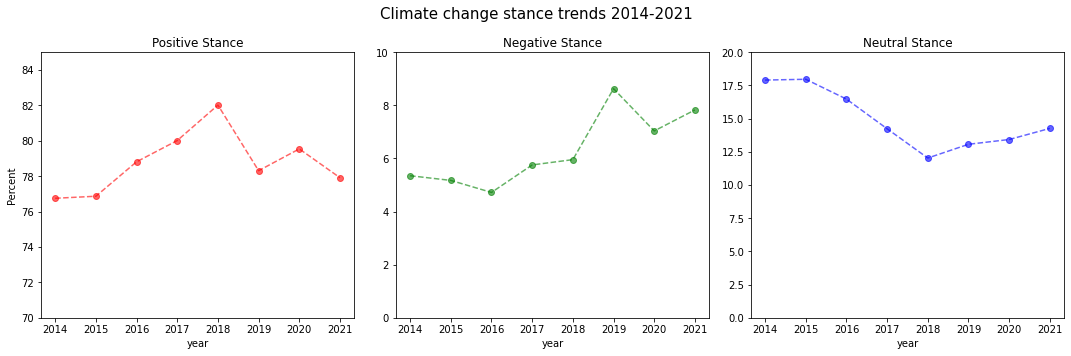

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].plot(2000+accs.T[0][accs.T[1]==1],accs.T[2][accs.T[1]==1]*100,'o--',c='red'
         ,alpha=0.6,label="Pos")
axes[0].title.set_text('Positive Stance')
axes[0].set_ylim([70, 85])
axes[0].set_xlabel('year',fontsize=10)
axes[0].set_ylabel('Percent',fontsize=10)

axes[1].plot(2000+accs.T[0][accs.T[1]==-1],accs.T[2][accs.T[1]==-1]*100,'o--',
         c='green',alpha=0.6,label='Neg')
axes[1].title.set_text('Negative Stance')
axes[1].set_ylim([0, 10])
axes[1].set_xlabel('year',fontsize=10)


axes[2].plot(2000+accs.T[0][accs.T[1]==0],accs.T[2][accs.T[1]==0]*100,'o--',
         c='blue',alpha=0.6,label='Neu')
axes[2].title.set_text('Neutral Stance')
axes[2].set_ylim([0, 20])
axes[2].set_xlabel('year',fontsize=10)


fig.suptitle("Climate change stance trends 2014-2021",fontsize=15)
plt.tight_layout()

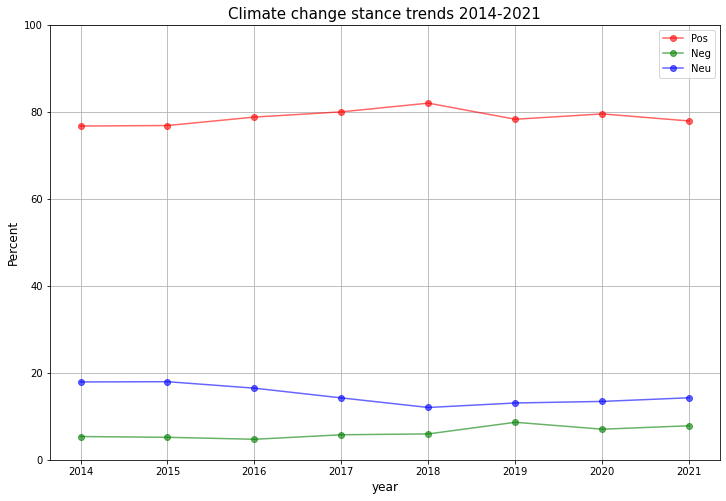

In [ ]:
plt.figure(figsize=(12,8))


plt.plot(2000+accs.T[0][accs.T[1]==1],accs.T[2][accs.T[1]==1]*100,'o-',c='red'
         ,alpha=0.6,label="Pos")
plt.plot(2000+accs.T[0][accs.T[1]==-1],accs.T[2][accs.T[1]==-1]*100,'o-',
         c='green',alpha=0.6,label='Neg')
plt.plot(2000+accs.T[0][accs.T[1]==0],accs.T[2][accs.T[1]==0]*100,'o-',
         c='blue',alpha=0.6,label='Neu')
plt.legend(loc='best')
plt.ylim(0,100)
plt.grid()
plt.xlabel('year',fontsize=12)
plt.ylabel('Percent',fontsize=12)
plt.title("Climate change stance trends 2014-2021",fontsize=15)
plt.show()